# Zestimate Improvements



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

color = sns.color_palette()

In [2]:
import xgboost as xgb

ImportError: No module named xgboost

In [2]:
properties = pd.read_csv("./properties_2016.csv")
train = pd.read_csv("./train_2016.csv")

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.shape

(90811, 3)

In [4]:
train.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [23]:
data_dict = pd.read_excel("./zillow_data_dictionary.xlsx")

In [103]:
# Let's see what a sample submission looks like.

sample_sub = pd.read_csv("./sample_submission.csv")

In [104]:
# So we really need to come up with 6 predictions, one for each of these different time periods.
# This seems to preclude us from using any sort of time related data that we don't know yet, like the state
# of the housing market, unless we want to use other people's predictions for that or come up with our own.

sample_sub.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


In [26]:
data_dict

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


In [74]:
df = pd.merge(train, properties, on="parcelid", how="left")

In [75]:
df['transactiondate'] = pd.to_datetime(df['transactiondate'])

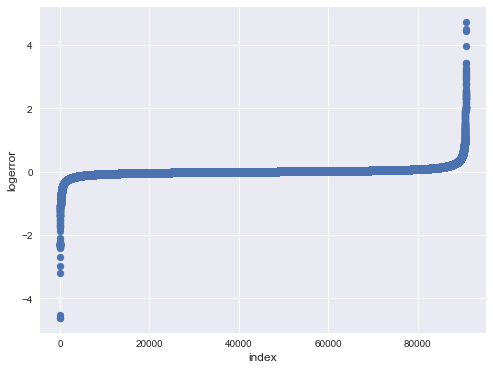

In [88]:
# Let's look at the distribution of the target variable, logerror

plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [92]:
# There's a really nice normal distribution on log error.

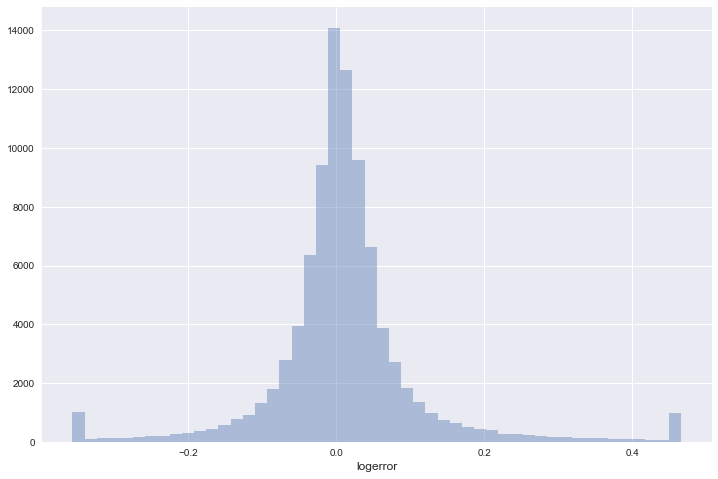

In [91]:
ulimit = np.percentile(df.logerror.values, 99)
llimit = np.percentile(df.logerror.values, 1)
df['logerror'].ix[df['logerror'] > ulimit] = ulimit
df['logerror'].ix[df['logerror'] < llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

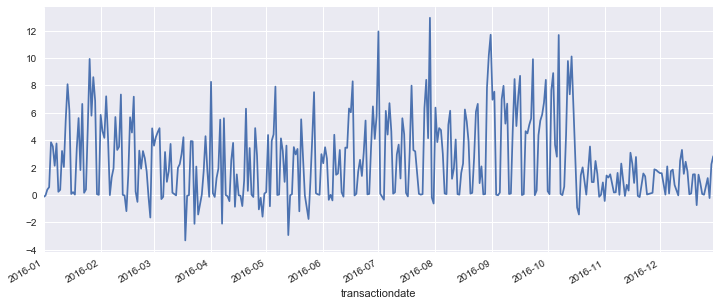

In [95]:
# Interesting to look at log error over time.  There's a lot more error after halfway through october 2016, maybe 
# the model that they were using changed?

grouped = df.groupby('transactiondate').sum()

plt.figure(figsize=(12,5))
grouped.logerror.plot()

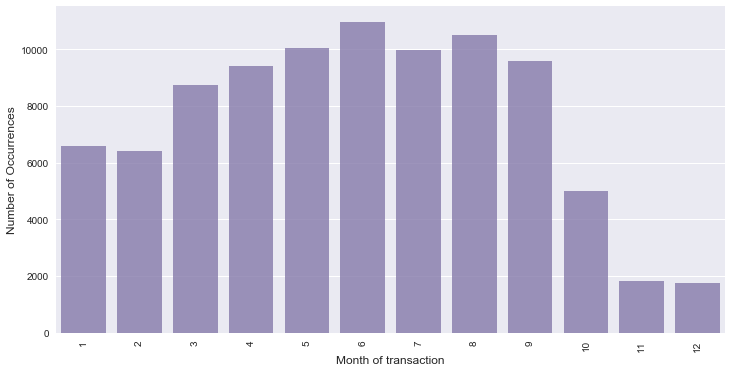

In [98]:
df['transaction_month'] = df['transactiondate'].dt.month

cnt_srs = df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

## Data Cleaning

In [76]:
# deleting the fireplace flag because we have another measure of count of fireplaces.

del(df['fireplaceflag'])

In [44]:
finished_cols = [c for c in df.columns if "finished" in c]
df[finished_cols].head(10).T

,0,1,2,3,4,5,6,7,8,9
finishedfloor1squarefeet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,853.0,NaN,NaN
calculatedfinishedsquarefeet,1684.0,2263.0,2217.0,839.0,2283.0,3067.0,1297.0,1763.0,796.0,1260.0
finishedsquarefeet12,1684.0,2263.0,2217.0,839.0,2283.0,3067.0,1297.0,1763.0,796.0,1260.0
finishedsquarefeet13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
finishedsquarefeet15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
finishedsquarefeet50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,853.0,NaN,NaN
finishedsquarefeet6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
df.architecturalstyletypeid.value_counts()

7.0     221
8.0      16
2.0      11
21.0      8
3.0       4
10.0      1
Name: architecturalstyletypeid, dtype: int64

In [82]:
from sklearn.preprocessing import LabelEncoder

In [101]:
le = LabelEncoder()
colors = le.fit_transform(df.loc[df['architecturalstyletypeid'].notnull(), 'architecturalstyletypeid'])

color_labels = ['red','blue','green','black','yellow','purple']

color_map = [color[i] for i in colors]

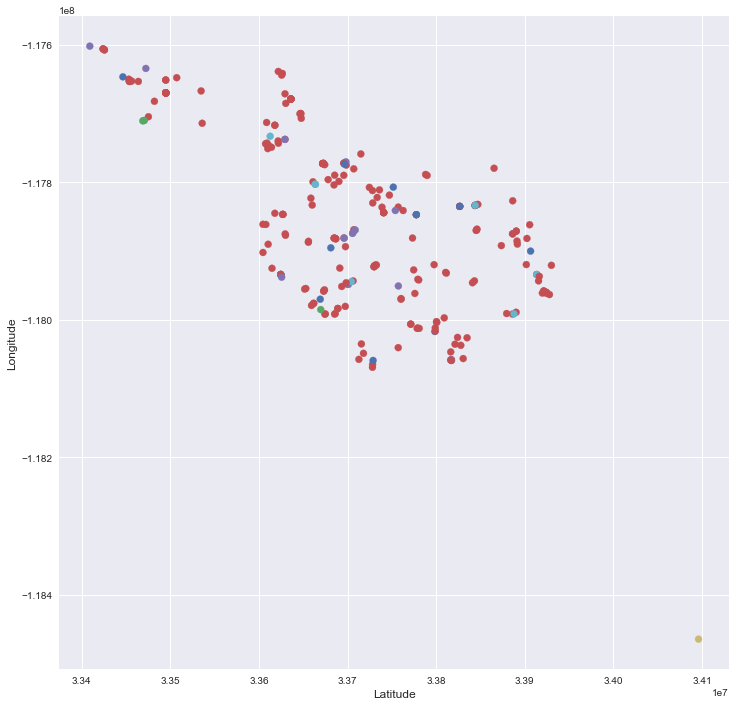

In [102]:
# There's a ton of missing values in architectural type, I thought maybe there would be some clustering in where
# the houses of different types are, but that doesn't seem to be the case.

plt.figure(figsize=(12,12))

plt.scatter(x=df[df['architecturalstyletypeid'].notnull()].latitude.values,
              y=df[df['architecturalstyletypeid'].notnull()].longitude.values,
              c=color_map)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

In [ ]:
# Let's try plotting these houses on a scatter with lat and lon to see the geographic breakdown of locations

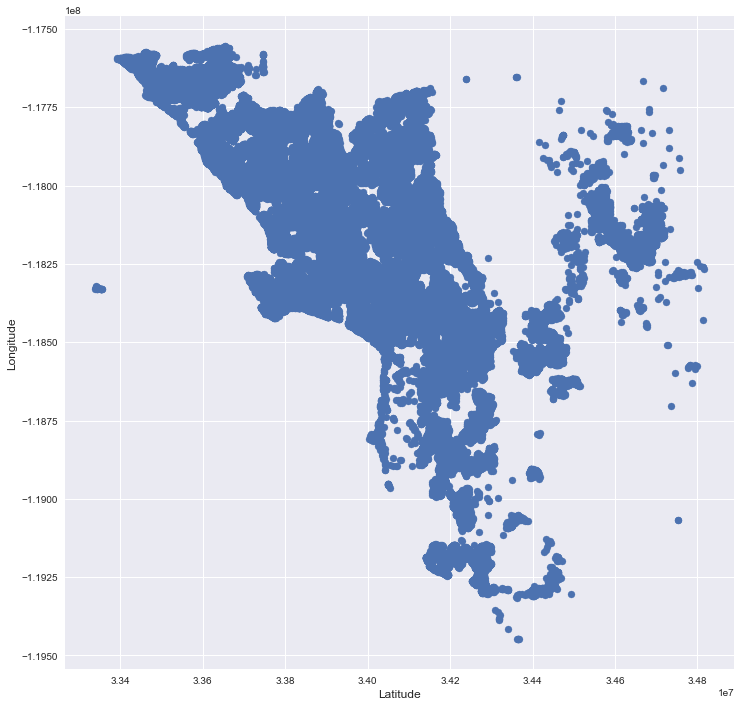

In [85]:
plt.figure(figsize=(12,12))

plt.scatter(x=df.latitude.values,
              y=df.longitude.values)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()